<img src="https://sdgcompass.org/wp-content/uploads/2016/04/global-goals_05_1.jpg" alt="SDG5" style="width: 200px;" align="right"/>

# Sentiment Analysis of Gender Equality Discourse on Twitter

[Dr David Johnson](http://djson.io), *Consultant Data Scientist*, [UNESCAP-SD](http://www.unescap.org/our-work/statistics)

<sub><sup>[Submission metadata](#MISDR+checklist)</sup></sub>

## 1. Description 

*SDG 5: Achieve gender equality and empower all women and girls* already has established indicators to measure progress towards various specific targets in this area. To investigate if something like public discourse such as Twitter feeds could act as a proxy to SDG 5 measurement, this notebook documents an example of utilizing simple data mining on archives of tweets while demonstrating the use of big data processing technologies to deal with large semi-structured datasets.

Hypothesis: countries with more open discussion about gender inequality are more likely to rank better on the Gender Inequality Index (GDI) or other established measures.

Potential problems:
 - Twitter is not equally popularly used across different countries.
 - Discussing gender inequality issues may not mean there is less gender equality, but could indicate the opposite.
 
But:
 - We can try and determine if public discourse on gender inequality in general could be used as a measure.
 - Applying the sentiment analyses to other sources of discourse in countries that Twitter is less relevant can demonstrate the potential for how a project can be put into a other national contexts. e.g. Discourse taken from other kinds of social networks, transcribing public radio shows, news, blogs etc. instead of online social media.

## 2. Data collection

### Data sources

To collect some data, we used Twitter's public API to get two datasets per country - a list of users who identify themselves somehow with being associated with a country, and then by using this list of users we collect a sample of tweets. The assumption is that tweets by these users can constitute a sample of tweets categorized by country.

We use `tweepy`, a Python module that wraps up the calls needed to be made to the Twitter API in a easy-to-use programming API. Two scripts, one called `get_users.py` to retrieve a sample of Twitter users, and a second script `get_tweets.py` to retrieve a sample of tweets for a given a list of users.

There are however several challenges to the data collection process:

1. Twitter's public API puts rate limits on pulling data, a limit to the velocity of data we can gather. This may cause the collection process to become long-running and may require a computer to be on and collecting data for a number of days.
2. The size of the datasets collected can be estimated, but not predicted. This is because individual tweets may vary in length and so we can estimate a maximum size and work down from that. The challenge here is of volume and ensuring we have a computer with enough capacity to store the collected datasets.

We address these challenges in two ways: by (1) automating the collection process and (2) leveraging cloud computing for data storage and processing.

### Leveraging cloud computing

In early experiments with using the `tweepy` Python module, we found that once scaling up to retrieving data from multiple users (100s to 1000s) would begin to take hours, and in some cases days due to Twitter's rate limiting policy. Once the rate limit had been exceeded (180 requests within each 15 minute time window), `tweepy` would pause until the rate limit window had refreshed. This meant that there was a requirement to run these collection processes as very long running processes and a computer would be required to be switched-on for long periods of time in order to complete this task.

To achieve this, we leverage Amazon's EC2 (Elastic Compute Cloud) to set up a long-running cloud server that we could run the collection process on. We set up a `t2.micro` instance in `eu-west-1` region (EU Republic of Ireland) with the following specifications:

- OS: Canonical Ubuntu 16.04 LTS, amd64 xenial image built on 2017-10-26
- Image size: 8GB
- Hardware: 1 vCPU, 1 GiB RAM
- Cost: USD0.0116 per hour, 6 CPU credits per hour
- Storage: 100 GiB EBS (Elastic Block Storage) in `eu-west-1a` region, unencrypted SSD.

We chose to use a `t2.micro` sized EC2 image as the collection process is not computationally intensive, but supported this with 100 GiB of extra data storage to ensure we have enough space to create our datasets.

### Automating the collection process

The long-running nature of collecting a large number of tweets means that we have to automate the process. To do this, we can run our scripts in a headless background process, using the following linux command:

```
nohup python3 -u get_tweets.py indonesia </dev/null >/dev/null 2<&1 &
```

`python3 -u get_tweets.py indonesia` is the core command that runs the `get_tweets.py` process with the argument `indonesia` that picks up a file previously generated by `get_users.py` called `indonesia_users.csv`.

`nohup` is a POSIX command to ignore the HUP signal (hangup signal). What we found was that we can execute the core command above in background mode by suffixing the command with `&`, however if we logged out of the terminal session the HUP signal would be called and the command would terminate on exit. Using `nohup` gets around this.

`</dev/null >/dev/null 2<&1` redirects the standard output `stdout` and standard error `stderr` streams to `/dev/null` essentially discarding the streams. This could be rewritten to write to file, but in our case we do not wish to log any output from the standard output or error streams.

We manually run the `get_users.py` script for a subset of UNESCAP countries (Australia, Hong Kong, India, Indonesia, Malaysia, New Zealand, Philippines, Singapore, Sri Lanka, Thailand) as these processes took less than 1 minute per country. The countries that we chose were partly selected based on the EF English Proficiency Index (https://www.ef.sg/epi/regions/asia/) where we want to select countries who are most likely to use Twitter in English. China was excluded due to the Twitter service being unavailable to their population, Vietnam due to low usage of Twitter in the country, and South Korea and Japan were excluded because although their English proficiency is high, their usage of Twitter is more greatly biased to Korean and Japanese respectively than the other selected countries.

Next, we ran each of the following commands in linux to collect tweets samples by country.
```
nohup python3 -u get_tweets.py australia 320 </dev/null >/dev/null 2<&1 &
nohup python3 -u get_tweets.py "hong kong" 3200 </dev/null >/dev/null 2<&1 &
nohup python3 -u get_tweets.py india 3200 </dev/null >/dev/null 2<&1 &
nohup python3 -u get_tweets.py indonesia 320 </dev/null >/dev/null 2<&1 &
nohup python3 -u get_tweets.py malaysia 320 </dev/null >/dev/null 2<&1 &
nohup python3 -u get_tweets.py "new zealand" 320 </dev/null >/dev/null 2<&1 &
nohup python3 -u get_tweets.py philippines 320 </dev/null >/dev/null 2<&1 &
nohup python3 -u get_tweets.py singapore 320 </dev/null >/dev/null 2<&1 &
nohup python3 -u get_tweets.py "sri lanka" 320 </dev/null >/dev/null 2<&1 &
nohup python3 -u get_tweets.py thailand 320 </dev/null >/dev/null 2<&1 &
```

This produced the following set of files, sampling 1020 users and requesting the most recent 320 tweets per user. Note that for the Hong Kong and India datasets, the request was set up to ask for the last 3200 tweets per user but the sample size was reduced for timeliness reasons. On the 320 tweet setting the harvest took 3-5 hours. On the 3200 tweet setting, the harvest would take about 1 day.

- [australia_tweets.csv](https://s3-eu-west-1.amazonaws.com/escap-twitter-project/australia_tweets.csv) (26.7MB)
- [hong kong_tweets.csv](https://s3-eu-west-1.amazonaws.com/escap-twitter-project/hong+kong_tweets.csv) (163.7MB)
- [india_tweets.csv](https://s3-eu-west-1.amazonaws.com/escap-twitter-project/india_tweets.csv) (156.7MB)
- [indonesia_tweets.csv](https://s3-eu-west-1.amazonaws.com/escap-twitter-project/indonesia_tweets.csv) (41.6MB)
- [malaysia_tweets.csv](https://s3-eu-west-1.amazonaws.com/escap-twitter-project/malaysia_tweets.csv) (41MB)
- [new zealand_tweets.csv](https://s3-eu-west-1.amazonaws.com/escap-twitter-project/new+zealand_tweets.csv) (57.9MB)
- [philippines_tweets.csv](https://s3-eu-west-1.amazonaws.com/escap-twitter-project/philippines_tweets.csv) (32.7MB)
- [singapore_tweets.csv](https://s3-eu-west-1.amazonaws.com/escap-twitter-project/singapore_tweets.csv) (12.4MB)
- [sri lanka_tweets.csv](https://s3-eu-west-1.amazonaws.com/escap-twitter-project/sri+lanka_tweets.csv) (22.5MB)
- [thailand_tweets.csv](https://s3-eu-west-1.amazonaws.com/escap-twitter-project/thailand_tweets.csv) (21.2MB)


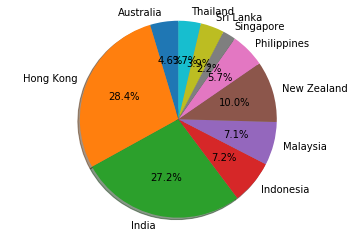

In [1]:
# Plot a pie chart showing proportions of data set sizes in total set
import matplotlib.pyplot as plt
labels = ['Australia', 'Hong Kong', 'India', 'Indonesia', 'Malaysia', 'New Zealand', 'Philippines', 'Singapore', 'Sri Lanka', 'Thailand']
sizes = [26.7, 163.7, 156.7, 41.6, 41, 57.9, 32.7, 12.4, 22.5, 21.2]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

Total size of input datasets: 576.4MB.
Total time: ~7 days.
Total cost ~USD35.00.

To run the following Twitter API examples you will need to log into Twitter and set up an API key. You can find out how to do this here: https://www.gabfirethemes.com/create-twitter-api-key/

In [2]:
# Enter your Twitter API key and access tokens here
api_key = 'GVnHQ6rkd1UGQKY9xSX9NupCD'
api_secret = 'zzhTxznO8EKGaD2hQSo4H4ZPFwkkPfFzR8HUlVtVNBQOaQw6bp'
access_token = '213419166-Z2sANHOWhM26bxBtFMBBeAXVAz19DGvBMYT3DqoM'
access_token_secret = 'BDWCtdMtyjUS4gNHVspdRM9GrIusDoeBt0sYJrIiadDMg'

First let set the country of context:

In [3]:
country = 'hong kong'

### Collecting users per country

To collect users per country, we use a script called `get_users.py`. Querying the Twitter API using the `tweepy.API.search_users` function, we simply search for the country name on a user profile. If the country name appears in any of the user profile metadata we add it to our country user list and write it to a CSV file with the filename template of `<country>_users.csv`.

The following snippet demonstrates querying for users, but outputs the results to the standard output rather than writing to the CSV file. This snippet queries for the maximum number of users available from the Twitter API (50).

In [ ]:
import tweepy

# the header of the CSV file
print((
    'id',
    'screen_name',
    'name',
    'created_at',
    'followers_count',
    'notifications',
    'time_zone',
    'favourites_count',
    'protected',
    'description',
    'statuses_count',
    'listed_count',
    'friends_count',
    'following',
    'location',
    'lang',
    'geo_enabled',
    'verified'
))

# Auth Tweepy object
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit_notify=True, wait_on_rate_limit=True)

# Get all users by a simple query on country
page_count = 1
user_count = 0
user_set = set()
while page_count < 6:
    try:
        users = api.search_users(q=country, page=page_count)
    except tweepy.error.TweepError as error:
        if error.api_code == 44:
            print('No more pages')
        break
    for user in users:
        if user.screen_name not in user_set:
            line = (
                user.id,
                user.screen_name,
                user.name,
                user.created_at,
                user.followers_count,
                user.notifications,
                user.time_zone,
                user.favourites_count,
                user.protected,
                user.description,
                user.statuses_count,
                user.listed_count,
                user.friends_count,
                user.following,
                user.location,
                user.lang,
                user.geo_enabled,
                user.verified
            )
            print(line)
            user_set.add(user.screen_name)
            user_count += 1
    page_count += 1
print("\n\n Done: Obtained {} users".format(user_count))


As a result we end up with a set of CSV files containing sample user profiles. For provenance reasons we additionally add metadata relating to how we found these user profiles and when they were collected via the Twitter API. 

A sample taken from the India users CSV file (already harvested previously) is shown below.

In [5]:
import pandas as pd
# Open <country>_users.csv and print last 5 rows
users_df = pd.read_csv('data/{country}_users.csv'.format(country=country).replace(' ', '+'))
users_df.sample(5)

,id,screen_name,name,created_at,followers_count,notifications,time_zone,favourites_count,protected,description,statuses_count,listed_count,friends_count,following,location,lang,geo_enabled,verified
513,341439411,KentEwing1,Kent Ewing,2011-07-24 10:56:49,415,False,Alaska,85,False,A resident of Hong Kong for more than 20 years...,265,22,70,False,Hong Kong,en,False,False
555,3388753100,hkspeedking,HKSpeedKing,2015-08-30 04:11:13,819,False,Melbourne,3525,False,Free tips for Hong Kong horse racing. Speed ra...,7356,12,68,False,"Victoria, Australia",en,False,False
489,327811571,HKProblems,Hong Kong Problems,2011-07-02 05:50:34,5382,False,NaN,47,False,Okay. Where did my Octopus Card go? #hkproblems,670,79,174,False,Not China.,en,True,False
684,135323190,ArchitectureBVN,BVN,2010-04-21 00:20:00,6270,False,Sydney,198,False,BVN has won 8 Sulman awards. Located in Brisba...,4945,0,983,False,Australia,en,True,False
677,88047724,MO_LANDMARKHK,The Landmark MO,2009-11-06 22:22:09,1171,False,Hong Kong,1854,False,A chic boutique hotel in the heart of Hong Kon...,1693,64,189,False,Hong Kong,en,True,False


### Collecting tweets by country

To collect tweets per country, we use as input to our `get_tweets.py` script the outputs from out `get_users.py` script. In this case, we open a matching country's `<country>_users.csv` file and iterate through each user profile found in the file. For each user we request using `tweepy.Cursor` the last 320 tweets from the specified user's timeline. We iterate through these results and write them to a CSV file `<country>_tweets.csv`.

The following snippet demonstrates querying for tweets, but outputs the results to the standard output rather than writing to the CSV file. This snippet queries on 10 user profiles and requests only 32 tweets per profile.

In [ ]:
import tweepy

# Load the users CSV file generated by get_users.py
users_df = pd.read_csv(
    'data/{country}_users.csv'.format(country=country).replace(' ', '+'), 
    dialect='excel')
users = users_df['screen_name'].sample(10)

# the header of the CSV file
print((
    'user_id', 
    'user_screen_name', 
    'user_friends_count', 
    'user_followers_count',
    'user_tweets_count', 
    'user_created_at', 
    'tweet_id', 
    'tweet_timestamp',
    'tweet_source', 
    'tweet_retweet_count', 
    'tweet_favorited_count', 
    'tweet_text',
    'tweet_longitude', 
    'tweet_latitude'
))

max_number_of_tweets = 32

# For each user, request up to max_number_of_tweets
count = 0
for screen_name in users:
    for tweet in tweepy.Cursor(
        api.user_timeline, screen_name=screen_name).items(max_number_of_tweets):
        print(tweet.text)
        if tweet.geo is not None:
            longitude = tweet.coordinates['coordinates'][0]
            latitude = tweet.coordinates['coordinates'][1]
        else:
            longitude = latitude = None
        line = (
        tweet.author.id, tweet.author.screen_name, tweet.author.friends_count,
        tweet.author.followers_count, None, tweet.author.created_at, tweet.id,
        tweet.created_at, tweet.source, tweet.retweet_count, tweet.favorite_count,
        tweet.text.encode('utf8'), longitude, latitude)
        print(line)
print('\n\n Done: Obtained all Tweets')

As discussed earlier in [Automating the collection process](#Automating the collection process), this script is run as a background process on a cloud server. A sample taken from the Singapore tweets CSV file (harvested earlier already) is shown below.

In [6]:
import pandas as pd
tweets_df = pd.read_csv('data/{country}_tweets.csv'.format(country=country).replace(' ', '+'))
tweets_df.sample(5)

,user_id,user_screen_name,user_friends_count,user_followers_count,user_tweets_count,user_created_at,tweet_id,tweet_timestamp,tweet_source,tweet_retweet_count,tweet_favorited_count,tweet_text,tweet_longitude,tweet_latitude
286257,210450261,IssamAhmed,2068,7605,NaN,2010-10-31 13:24:57,633544641934045184,2015-08-18 07:43:07,Twitter Web Client,1,0,"b""She's back. Clinton aide Huma Abedin under t...",NaN,NaN
136905,139738464,mj_lee,1082,34676,NaN,2010-05-03 14:41:10,910521591989235712,2017-09-20 15:10:38,TweetDeck,25,0,b'RT @DanaBashCNN: Insightful piece from @tedb...,NaN,NaN
427312,605773445,HongKongdaily,9,5759,NaN,2012-06-11 21:48:13,899691849643810818,2017-08-21 17:57:07,dlvr.it,0,0,b'Uber raises Hong Kong fares amid legal tangl...,NaN,NaN
410691,1639530362,yuenok,1204,2298,NaN,2013-08-02 04:00:40,899220443613151232,2017-08-20 10:43:55,Twitter for iPhone,96,0,b'RT @haritho: This.is iconic. The last protes...,NaN,NaN
470516,95401056,sumeet_chat,367,721,NaN,2009-12-08 11:22:07,760320970049544197,2016-08-02 03:46:59,Twitter for iPhone,122,0,"b'RT @Reuters: U.S. weighs dangers, benefits o...",NaN,NaN


**Note that because of limitations on the Twitter API Developer Agreement and Policy, the original full datasets that were used in this work cannot be shared directly. However we have included CSV files containing the user IDs and tweet IDs that can be used should you wish to retrieve all of the original data.**

## 3. Data processing

Now that we have collected sample datasets of tweets categorized by different countries, we want to process this data to extract a sentiment metric for each tweet. To do this, we must preprocess the tweets, tokenize each tweet, build a term co-occurence matrix, then perform the sentiment analysis.

### Data preprocessing

For regular prose we would normally use the Natural Language ToolKit `nltk`'s own tokenizer, however tweets often have other non-English structures such as retweets `RT`, at mentions `@user`, hashtags `#hashtag`, URLs and even emoticons `:-)` embedded in them. To deal with these, we implement our own tokenizer.

In [7]:
from __future__ import unicode_literals
import re, operator, json, string

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]   
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

def preprocess(s, lowercase=False):
    b = bytes(s, encoding='ascii')
    s = b.decode('unicode-escape')
    tokens = tokens_re.findall(s)
    tokens = [token[2:] if token.startswith("b'") else token for token in tokens]
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

### Find term frequencies

Next, we build a table of term frequencies. We tokenize each tweet, remove any irrelevant tokens, and count up all of the terms.

In [8]:
import nltk
nltk.download('stopwords')
from collections import Counter
from nltk.corpus import stopwords

# Open the tweets CSV file
df = pd.read_csv('data/{country}_tweets.csv'.format(country=country).replace(' ', '+'))

# Build a stopwords list from common stopwords, punctuation, and others that we know about
punctuation = list(string.punctuation)
other_stopwords = ['rt', 'via']
stop = stopwords.words('english') + punctuation + other_stopwords

# Get only the tweet_text column and take a sample. Normally would run on full dataset
# tweet_text = df['tweet_text'].sample(50000)
tweet_text = df['tweet_text']

print('Processing {} tweets'.format(tweet_text.count()))
count_all = Counter()

for tweet in tweet_text:  
    # preprocess the tweet and tokenize as per previous step
    terms_all = [term for term in preprocess(tweet, lowercase=True)]
    # remove stopwords from the tweet terms
    terms_stopwords_removed = [term for term in terms_all if term not in stop]
    # filter out words deemed to short to be relevant (3 characters or less)
    terms_short_words_removed = [token for token in terms_stopwords_removed if len(token) > 3]
    # filter out terms beginning with hastags or at
    terms_only = [term for term in terms_short_words_removed if not term.startswith(
        ('#', '@', 'http', 'https'))]
    # Update the counter
    count_all.update(terms_only)
print('Finished')

[nltk_data] Downloading package stopwords to /Users/dj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing 697711 tweets
Finished


In [9]:
# Print the first 10 most frequent words found in tweets that mention 'gender'
print(count_all.most_common(10))

[('hong', 70254), ('kong', 65039), ('china', 27574), ('says', 15626), ('great', 14193), ('today', 14161), ('time', 13876), ('chinese', 13747), ('like', 13103), ("it's", 13102)]


### Find co-occurences

In [10]:
from collections import defaultdict

co_matrix = defaultdict(lambda : defaultdict(int))
 
# f is the file pointer to the JSON data set
for tweet in tweet_text:  
    terms_all = [term for term in preprocess(tweet, lowercase=True)]
    terms_stopwords_removed = [term for term in terms_all if term not in stop]
    terms_short_words_removed = [token for token in terms_stopwords_removed if len(token) > 3]
    terms_only = [term for term in terms_short_words_removed if not term.startswith(
        ('#', '@', 'http', 'https'))]
 
    # Build co-occurrence matrix
    for i in range(len(terms_only)-1):            
        for j in range(i+1, len(terms_only)):
            term1, term2 = sorted([terms_only[i], terms_only[j]])                
            if term1 != term2:
                co_matrix[term1][term2] += 1

In [11]:
co_matrix_max = []
# For each term, look for the most common co-occurrent terms
for t1 in co_matrix:
    t1_max_terms = sorted(
        co_matrix[t1].items(), key=operator.itemgetter(1), reverse=True)[:5]
    for t2, t2_count in t1_max_terms:
        co_matrix_max.append(((t1, t2), t2_count))
# Get the most frequent co-occurrences
terms_max = sorted(co_matrix_max, key=operator.itemgetter(1), reverse=True)
print(terms_max[:5])

[(('hong', 'kong'), 72064), (('china', 'hong'), 5326), (('china', 'kong'), 4870), (('hong', "kong's"), 4633), (('china', 'south'), 3885)]


### Unsupervised sentiment analysis

- Based on Thumbs Up or Thumbs Down? paper https://arxiv.org/abs/cs/0212032
- Method replicated from https://marcobonzanini.com/2015/05/17/mining-twitter-data-with-python-part-6-sentiment-analysis-basics/

#### Computing Term Probabilities (rewrite text)

The method used in this work builds on a [series of blog posts](https://marcobonzanini.com/2015/05/17/mining-twitter-data-with-python-part-6-sentiment-analysis-basics/) by [Marco Bonzanini](https://marcobonzanini.com/about/), which in-turn builds on the class approach by Peter Turney in his paper *Thumbs Up or Thumbs Down? Semantic Orientation Applied to Unsupervised Classification of Reviews*. Turney's approach is by no means the best approach to sentiment analysis, but is a seminal work that is straightforward to understand and is a good example of unsupervised feature extraction.

First, we define the Semantic Orientation, $SO$, of a word as the difference between its associations with positive and negative words. In practice, we want to calculate "how close" a word is with terms like *good* and *bad*. The chosen measure of "closeness" is Pointwise Mutual Information (PMI), calculated as follows ($t_1$ and $t_2$ are terms):

\begin{equation}
PMI(t_1t_2) = log\frac{P(t_1\wedge t_2)}{P(t_1)\cdot  P(t_2)}
\end{equation}

In Turney's paper, $SO$ is calculated against *excellent* and *poor*. We extend the vocabulary of positive and negative terms to sets of mutiple positive and negative terms. Using $V^{+}$ and a vocabulary of positive terms and $V^{-}$ for the negative ones, $SO$ of a term $t$ is:

\begin{equation}
SO(t) = \sum_{t'\in V^+}PMI(t, t')-\sum_{t'\in V^-}PMI(t, t')
\end{equation}


In order to compute $P(t)$, the probability of observing the term $t$, and $P(t_1 \wedge t_2)$ (the probability of observing the terms $t_1$ and $t_2$ occurring together) calculate term frequencies and term co-occurrences again. Given a set of documents (in our case, tweets) $D$, we define the Document Frequency, $DF$, of a term as the number of documents where the term occurs. The same definition can be applied to co-occurrent terms. Hence, we can define our probabilities as:

\begin{equation}
P(t) = \frac{DF_{(t)}}{\left | D \right |}
\end{equation}


\begin{equation}
P(t_1 \wedge t_2) = \frac{DF_{(t_1 \wedge t_2)}}{\left | D \right |}
\end{equation}

In previous steps, the frequency for single terms was stored in the dictionaries `count_single` and `count_stop_single` (the latter doesn't store stop-words), while the document frequency for the co-occurrencies was stored in the co-occurrence matrix `co_matrix`.

This is how we can compute the probabilities:

In [12]:
# n_docs is the total number of tweets - length (number of rows) of the input data
p_t = {}
p_t_com = defaultdict(lambda : defaultdict(int))

n_docs = len(df)

for term, n in count_all.items():
    p_t[term] = n / n_docs
    for t2 in co_matrix[term]:
        p_t_com[term][t2] = co_matrix[term][t2] / n_docs

#### Computing the SO

We then load two vocabularies for positive and negative terms using the opinion lexicon corpus (see Bing Liu, Minqing Hu and Junsheng Cheng. *Opinion Observer: Analyzing and Comparing Opinions on the Web.* Proceedings of the 14th International World Wide Web conference (WWW-2005), May 10-14, 2005, Chiba, Japan) as our positive and negative word sets:

In [13]:
positive_vocab = []
for pos_word in open('data/opinion-lexicon/positive-words.txt', 'rb').readlines()[35:]:
    positive_vocab.append(pos_word.decode('unicode-escape').rstrip())
negative_vocab = []
for neg_word in open('data/opinion-lexicon/negative-words.txt', 'rb').readlines()[35:]:
    negative_vocab.append(neg_word.decode('unicode-escape').rstrip())

We can compute the $PMI$ of each pair of terms, and then compute the
$SO$ as described above:

In [14]:
import math
pmi = defaultdict(lambda : defaultdict(int))
for t1 in p_t:
    for t2 in co_matrix[t1]:
        denom = p_t[t1] * p_t[t2]
        pmi[t1][t2] = math.log2(p_t_com[t1][t2] / denom)
 
semantic_orientation = {}
for term, n in p_t.items():
    positive_assoc = sum(pmi[term][tx] for tx in positive_vocab)
    negative_assoc = sum(pmi[term][tx] for tx in negative_vocab)
    semantic_orientation[term] = positive_assoc - negative_assoc

The Semantic Orientation of a term will have a positive (negative) value if the term is often associated with terms in the positive (negative) vocabulary. The value will be zero for neutral terms, e.g. the PMI’s for positive and negative balance out, or more likely a term is never observed together with other terms in the positive/negative vocabularies.

We can print out the semantic orientation for some terms:

In [15]:
semantic_sorted = sorted(semantic_orientation.items(), 
                         key=operator.itemgetter(1), 
                         reverse=True)
top_pos = semantic_sorted[:10]
top_neg = semantic_sorted[-10:]
print(top_pos)
print(top_neg)
for gender_topic in (
    'women', 
    'girls',
    'woman',
    'girl',
    'female',
    'men',
    'boys',
    'man',
    'boy',
    'male',
    'gender',
    'equality',
    'inequality',
    'discrimination'
):
    if gender_topic in semantic_orientation.keys():
        print(gender_topic, semantic_orientation[gender_topic])

[('chef', 283.74073342529937), ('enjoy', 272.8687473701441), ('cuisine', 267.08918655715485), ('congratulations', 249.5294823520718), ('congrats', 238.36715955216818), ('award', 224.32630475803583), ('celebrate', 210.62271552643577), ('achievement', 209.8495056270691), ('experience', 202.85466733855395), ('charming', 193.96967654271734)]
[('abuse', -784.4090813028506), ('court', -811.5344601389297), ('amid', -843.3688716707776), ('could', -854.047007876441), ("china's", -855.6345522490202), ('beijing', -871.9834422045019), ('death', -896.040176751387), ('attack', -938.8289449099872), ('chinese', -997.304029480088), ('china', -1279.4394124529817)]
women -9.393397756384072
girls -58.47700892131763
woman -10.284167640950587
girl -139.12697590712327
female -222.05531190721032
boys -132.82048215067147
male -113.46727935279313
gender -200.82482163194157
equality 12.967619374547098
inequality -127.95633319854397
discrimination -249.12910204183424


### Using Gender Sentiment as an Index

To use these measures as an index, we could possibly try averaging out male and female keyword sentiments (e.g. average sentiment score for `women`, `girls`, `woman`, `female` for female sentiments and `men`, `boys`, `man`, `male` for male sentiments). We can then subtract one from the other to determine which set of keywords found the sentiment is biased towards. This may have dubious face validity but acts as a simple example. Given:

\begin{equation}
GS(c) = \frac{\sum_{t\in F_{c}}SO(t)}{\left |F_{c} \right |}-\frac{\sum_{t\in M_{c}}SO(t)}{\left |M_{c} \right |}
\end{equation}

where $F$ and $M$ are sets of female and male gender terms, and $c$ is set of terms for a given the country, we calculate a Gender Sentiment score $GS(c)$. We normalize these scores by looking for the $max(GS)$ and $min(GS)$ and scaling all the scores between $-1$ and $1$ ($<0$ being male biased, $>0$ being female biased. A more positive score towards a female bias should be interpreted as favourable give that SDG 5 and gender equality focuses on enabling women to have more equal rights with men, where the status quo is that men are already advantaged.


In [16]:
F = ('women', 'girls', 'woman','girl', 'female')
M = ('men', 'boys', 'man', 'boy', 'male')
SO_Fs = list(semantic_orientation[term] for term in F if term in semantic_orientation.keys())
SO_F_sum = sum(SO_Fs)
F_c_size = len(SO_Fs)
SO_Ms = list(semantic_orientation[term] for term in M if term in semantic_orientation.keys())
SO_M_sum = sum(SO_Ms)
M_c_size = len(SO_Ms)
print('{country},{gs},{tweet_count}'.format(
    country=country, gs=(SO_F_sum / F_c_size) - (SO_M_sum - M_c_size), tweet_count=len(df)))

hong kong,160.42038907686742,697711


The full set of data sets were processed using the above documented methods using a script `run_analysis.py` that generates the GS score for each country. Post processing is done to scale the scores and generate a comparative figure.

In [17]:
import pandas as pd
results = pd.read_csv('results.csv', index_col=0)
results

,gender_sentiment,tweet_count
country,,
hong kong,160.420389,697711
australia,41.004644,113728
india,34.763303,604627
philippines,-7.626444,138059
new zealand,-14.761185,255159
thailand,-24.446219,53297
singapore,-35.770106,50485
indonesia,-50.131598,171160
malaysia,-106.510823,172380


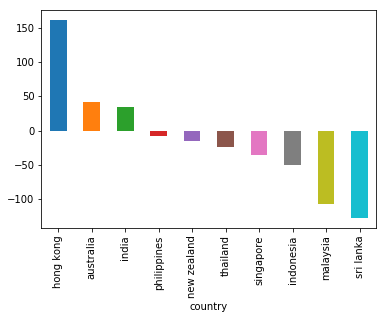

In [18]:
results['gender_sentiment'].plot.bar()
import matplotlib.pyplot as plt
plt.show()

### Limitations

Turney's approach is simple to understand, but simplistic in its modelling of language. There is no concept of anything other than "terms" that are all treated equally and filtered on a stop list. Relating terms to entities, events, and people may yield different results. Other aspects of natural language are also not considered, such as negation (e.g. "not bad" indicating negative or neutral, or in some cases if spoken by a British person could indicated understated positivity) or qualifiers such as "very good" that could be scored as being better than just "good".

In the context of gender (in)equality, it is also worth noting that sentiments in tweets may not necessarily relate well to measures of inequality. For example, many people may talk about gender issues or male/female topics because inequality is actively being dealt with in a postitive way, but the inequalities may not have actually yet been addressed. 

## 4. Observations

The method applied here takes a simplistic approach in attempting to gauge positive and negative sentiments associated with gender-specific terms found in the tweet corpus collected for each country. The method itself takes a simple "bag of words" approach to calculating the sentiments, and the accuracy of these measures is highly dependent on the frequency to which terms occur as well as matching within the opinion lexicon data. Non-English tweets are also not considered since this would require translations of the opinion lexicon and also translating the gender terms of interest.

A deeper look should be carried out into what terms or topics are more indicative to measuring sentiment in gender topics. It may also be worth looking into doing a correlation or regression analysis against existing gender indexes.

### Developing a Gender Sentiment Index

However, this could be used as a starting point to developing another indicator for SDG 5 based around a Gender Sentiment Index.

Improving the accuracy of the sentiment analysis is required and also it would be interesting to apply this method to countries who may have bigger data gaps in the social media - for example in China, Twitter data would not be available due to the ban on using the service there. However other sources of public discourse could be harvested, for example by using speech-to-text to gather radio chat.

Also, by leveraging APIs like Twitter, such an index could be tracked live by incorporating streaming data into a Web-hosted analysis, and plot a moving average over time.

In [19]:
x = results['gender_sentiment']
normalized = (x-min(x))/(max(x)-min(x))
results['gender_sentiment'] = normalized
results.columns = ['GS Index', 'Tweet count']
results

,GS Index,Tweet count
country,,
hong kong,1.000000,697711
australia,0.585021,113728
india,0.563332,604627
philippines,0.416024,138059
new zealand,0.391230,255159
thailand,0.357574,53297
singapore,0.318223,50485
indonesia,0.268316,171160
malaysia,0.072393,172380


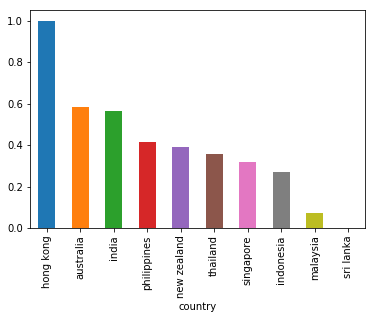

In [21]:
results['GS Index'].plot.bar()
plt.show()

## 5. MISDR checklist

A submission metadata file in **MISDR format** was included with this notebook.

*MISDR* (Minimum Information for Sustainable Development Research) is a draft proposal checklist and templates for metadata to as fully describe as possible research outputs of data-driven SDG research.

In [22]:
print(open('submission_metadata.txt').read())

[General metadata]
Identifier,ESCAP:000001
Submission date,12-15-2017
Title,Sentiment Analysis of Gender Equality Discourse on Twitter
Description,
Publications,
Related publications,
Project team,"Dr David Johnson, Christopher Sean Lovell"
Submitter contact email,david.johnson@djson.net

[Computational configuration]
Hardware,t2.micro on Amazon Web Services
Software,Python 3.6
OS,Ubuntu 16.04
Installed packages,"tweepy, jupyter, nltk"

[Context]
Country/region,Asia-Pacific region
SDGs,SDG5
Goal,"Experimentation, development of new measurement, proxy data"

[Data sources]
Organization,Twitter
Endpoint,Twitter API
License,Twitter Developer Agreement and Policy
